In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.Whh = nn.Linear(2, 2)
        self.Whx = nn.Linear(1, 2, bias = False)
        
        self.layer1 = nn.Linear(2 + 1, 64)
        self.layer2 = nn.Linear(64, 16)
        self.layer3 = nn.Linear(16, 1)
              
    
    def forward_RNN(self, x, hidden):
        
        hidden_next = torch.tanh(self.Whh(hidden) + self.Whx(x))
        return hidden_next
    

    def forward_DNN(self, x, hidden):
        
        X = torch.cat((x, hidden), 1)
        X = self.layer1(X).clamp(min = 0)
        X = self.layer2(X).clamp(min = 0)
        X = self.layer3(X)
        return X*(x-2)*(x+2)

    
def metropolis(hidden, model):
    total = 0
    x = torch.zeros((1,1))
    for i in range(50):
        psi_old = model.forward_DNN(x, hidden)
        
        x_new = x + torch.Tensor((2*np.random.random((1,1)) - 1))
        psi_new = model.forward_DNN(x_new, hidden)

        if (psi_new/psi_old)**2 > np.random.random():
            x = x_new
            total += 1
    return x.detach(), total

In [3]:
model = Model()
hidden = torch.zeros((1,2))
x = torch.zeros((1,1))
model.forward_RNN(x, hidden)

y = model.forward_DNN(x, hidden)
y.backward()

In [4]:
torch.manual_seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters())

epochs = 10
h = 0.01
#print(list(model.parameters()))

In [26]:
for epoch in range(epochs):
    P_acc = len(list(model.parameters()))*[0]
    E_acc = 0
    PE_acc = len(list(model.parameters()))*[0]
    N = 1000
    grad = 0
    for i in range(N):
        psi_total = 1
        hidden = torch.zeros((1,2))
        x = torch.zeros((1,1))

        hidden = model.forward_RNN(x, hidden)
        x = metropolis(hidden, model)[0]

        psi_plus  = model.forward_DNN(x+h, hidden) 
        psi       = model.forward_DNN(x, hidden)
        psi_minus = model.forward_DNN(x-h, hidden)
        
        psi_total *= psi
        
        lap1 = 1/psi*(psi_plus - 2*psi + psi_minus)/h**2
        pot1 = 0.5*x**2

        hidden = model.forward_RNN(x, hidden)
        x = metropolis(hidden, model)[0]

        psi_plus  = model.forward_DNN(x+h, hidden) 
        psi       = model.forward_DNN(x, hidden)
        psi_minus = model.forward_DNN(x-h, hidden)
        psi_total *= psi
        
        lap2 = 1/psi*(psi_plus - 2*psi + psi_minus)/h**2
        pot2 = 0.5*x**2
        
        E_L = (-0.5*(lap1 + lap2) + pot1 + pot2)[0]
        E_acc += E_L
        
        optimizer.zero_grad()
        psi_total.backward()

        for i, param in enumerate(model.parameters()):
            P_acc[i] += param.grad/psi_total[0]
            PE_acc[i] += E_L*param.grad/psi_total[0]
    
    E_acc = E_acc/N
    
    for i, param in enumerate(model.parameters()):
        #print(param.grad.shape)
        #print(PE_acc[i].shape)
        #print(P_acc[i].shape)
        #print(E_acc.shape)
        param.grad = 2/N*(PE_acc[i] - P_acc[i]*E_acc)
        grad += torch.sum(param.grad**2)
    
    optimizer.step()
    print(f"epoch: {epoch}, loss: {grad}")

epoch: 0, loss: 1004.6961059570312
epoch: 1, loss: 3145.35107421875
epoch: 2, loss: 6617.986328125
epoch: 3, loss: 5348.17578125
epoch: 4, loss: 8297.263671875
epoch: 5, loss: 3949.00439453125
epoch: 6, loss: 10971.0625
epoch: 7, loss: 4685.73388671875
epoch: 8, loss: 4234.69921875
epoch: 9, loss: 4245.8623046875


In [13]:
hidden = torch.zeros((1,2))
x = torch.zeros((1,1))
hidden = model.forward_RNN(x, hidden)

print(metropolis(hidden, model))

(tensor([[-0.5157]]), 28)


In [7]:
x1_array = []
x2_array = []
for i in tqdm(range(1000)):
    hidden = torch.zeros((1,2))
    x = torch.zeros((1,1))
    
    hidden = model.forward_RNN(x, hidden)
    
    x = metropolis(hidden, model)[0]
    x1_array.append(x)
    
    hidden = model.forward_RNN(x, hidden)
    x = metropolis(hidden, model)[0]
    x2_array.append(x)
    


100%|██████████| 1000/1000 [00:19<00:00, 51.17it/s]


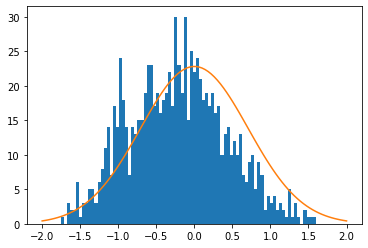

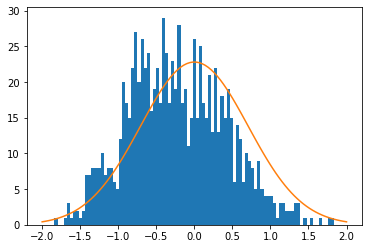

In [8]:
x1_array = np.array(x1_array)
x2_array = np.array(x2_array)

bins = np.linspace(-2, 2, 100)
dx = bins[1] - bins[0]

plt.hist(x1_array, bins=bins)
plt.plot(bins, 1000*dx/np.sqrt(np.pi)*np.exp(-bins**2))
plt.show()

plt.hist(x2_array, bins=bins)
plt.plot(bins, 1000*dx/np.sqrt(np.pi)*np.exp(-bins**2))
plt.show()

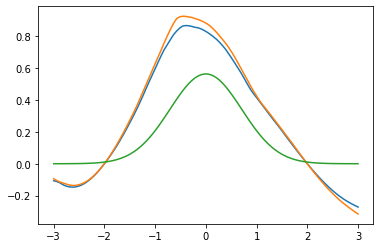

In [46]:
x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)

x = torch.zeros((100,1))
hidden = torch.zeros((100,2))
hidden = model.forward_RNN(x, hidden)

psi1 = model.forward_DNN(x_lin, hidden)[:,0].detach().numpy()

x = torch.zeros((1,1))
hidden = torch.zeros((1,2))
hidden = model.forward_RNN(x, hidden)
x = metropolis(hidden, model)[0]
hidden = model.forward_RNN(x, hidden)
hidden = hidden.repeat((100,1))

psi2 = model.forward_DNN(x_lin, hidden)[:,0].detach().numpy()


plt.plot(x_lin[:,0], psi1)
plt.plot(x_lin[:,0], psi2)
plt.plot(x_lin[:,0], 1/np.sqrt(np.pi)*np.exp(-x_lin[:,0]**2))